# Applied data analysis - Project

## Swiss products on Amazon

The goal of the project is to analyze the swiss products sold on Amazon based on product reviews from a certain period of time. The first challenge is to filter the data to only keep swiss products, which is not trivial. Secondly, we will have to perform analysis on the users comments and the notes they gave.

The first part is the data preparation so we can work with nice and useful data later on.

Description of data: http://jmcauley.ucsd.edu/data/amazon/

### Setup

This part is about fetching the data and making it nice to work with.

In [1]:
from pyspark import SparkContext
import pyspark.sql
import pandas as pd
import json

In [2]:
rdd = sc.textFile("hdfs:///datasets/amazon-reviews")

In [3]:
rdd

hdfs:///datasets/amazon-reviews MapPartitionsRDD[1] at textFile at NativeMethodAccessorImpl.java:-2

In [4]:
rdd.count()

152262068

In [5]:
rdd.first()

'{"reviewerID": "A00000262KYZUE4J55XGL", "asin": "B003UYU16G", "reviewerName": "Steven N Elich", "helpful": [0, 0], "reviewText": "It is and does exactly what the description said it would be and would do. Couldn\'t be happier with it.", "overall": 5.0, "summary": "Does what it\'s supposed to do", "unixReviewTime": 1353456000, "reviewTime": "11 21, 2012"}'

In [4]:
def is_json(myjson):
  try:
    json_object = json.loads(str(myjson))
  except (ValueError, Exception):
    return False
  return True


In [5]:
rdd = rdd.filter(is_json)
rdd = rdd.map(lambda x: json.loads(str(x)))

In [8]:
rdd.first()

{'asin': 'B003UYU16G',
 'helpful': [0, 0],
 'overall': 5.0,
 'reviewText': "It is and does exactly what the description said it would be and would do. Couldn't be happier with it.",
 'reviewTime': '11 21, 2012',
 'reviewerID': 'A00000262KYZUE4J55XGL',
 'reviewerName': 'Steven N Elich',
 'summary': "Does what it's supposed to do",
 'unixReviewTime': 1353456000}

|   field        | description |
|----------------|--------------------|
| reviewerID     | ID of the reviewer |
| asin           | ID of the product |
| reviewerName   | name of the reviewer |
| helpful        | helpfulness rating of the review |
| reviewText     | text of the review|
| overall        | rating of the product|
| summary        | summary of the review|
| unixReviewTime | time of the review (unix time)|
| reviewTime     | time of the review (raw)|

Plus for convenience, we will create a separate rdd that contains all the product IDs.

In [17]:
products = rdd.map(lambda x: (x['asin'], 1))
products.cache()

PythonRDD[16] at RDD at PythonRDD.scala:43

In [18]:
products.count()

142831980

In [19]:
uniqueProducts = products.reduceByKey(lambda a, b: a + b)

In [20]:
uniqueProducts.first()

('B00EDH41T2', 2)

In [21]:
uniqueProducts.count()

12650775

### Data filtering

Our first job is to filter out non-swiss products.

*insert here plan to achieve what explained above*

In [6]:
metaRdd = sc.textFile("hdfs:///datasets/amazon-reviews/metadata.json")

In [7]:
#metaRdd = metaRdd.filter(is_json)
#metaRdd = metaRdd.map(lambda x: json.loads(str(x)))

In [11]:
metaRdd.first()

"{'asin': '0001048791', 'salesRank': {'Books': 6334800}, 'imUrl': 'http://ecx.images-amazon.com/images/I/51MKP0T4DBL.jpg', 'categories': [['Books']], 'title': 'The Crucible: Performed by Stuart Pankin, Jerome Dempsey &amp; Cast'}"

We'll now turn this data into JSON objects with the eval function

In [8]:
filteredRdd = metaRdd.map(lambda x: eval(x))

In [13]:
filteredRdd.first()

{'asin': '0001048791',
 'categories': [['Books']],
 'imUrl': 'http://ecx.images-amazon.com/images/I/51MKP0T4DBL.jpg',
 'salesRank': {'Books': 6334800},
 'title': 'The Crucible: Performed by Stuart Pankin, Jerome Dempsey &amp; Cast'}

We only keep the entires with a brand

In [9]:
filteredRdd = filteredRdd.filter(lambda x: 'brand' in x)
filteredRdd.cache()

PythonRDD[4] at RDD at PythonRDD.scala:43

In [15]:
filteredRdd.first()

{'asin': '0000037214',
 'brand': 'Big Dreams',
 'categories': [['Clothing, Shoes & Jewelry', 'Girls'],
  ['Clothing, Shoes & Jewelry',
   'Novelty, Costumes & More',
   'Costumes & Accessories',
   'More Accessories',
   'Kids & Baby']],
 'imUrl': 'http://ecx.images-amazon.com/images/I/31mCncNuAZL.jpg',
 'price': 6.99,
 'related': {'also_viewed': ['B00JO8II76', 'B00DGN4R1Q', 'B00E1YRI4C']},
 'salesRank': {'Clothing': 1233557},
 'title': 'Purple Sequin Tiny Dancer Tutu Ballet Dance Fairy Princess Costume Accessory'}

We'll now load the list of swiss companies that we have collected in the other notebook

In [10]:
swissCompanies = pd.read_csv("swiss_companies.csv")

In [11]:
swissCompanies

,A. Favre & Fils,ABB Group,ACE Limited,Actelion,Adecco,Air Glaciers,Allseas,Alpa,Alternative Bank Schweiz,AMAG,...,Flug- und Fahrzeugwerke Altenrhein,Hello,Interhandel,SAPAL,Swiss Bank Corporation,Union Bank of Switzerland,UBS.1,Swissair,Economy of Switzerland,List of restaurants in Switzerland


In [13]:
swissCompaniesList = swissCompanies.columns.values.tolist()

In [14]:
swissCompaniesList

['A. Favre & Fils',
 'ABB Group',
 'ACE Limited',
 'Actelion',
 'Adecco',
 'Air Glaciers',
 'Allseas',
 'Alpa',
 'Alternative Bank Schweiz',
 'AMAG',
 'Antiquorum',
 'Arctic',
 'Ascom',
 'Atlanship SA',
 'Audemars Piguet',
 'Auto AG',
 'AutoForm',
 'Axpo',
 'Bally Shoe',
 'Bâloise',
 'Bamix',
 'Banque SYZ & Co SA',
 'Barry Callebaut',
 'Basilea Pharmaceutica',
 'Bata Shoes',
 'BB Biotech',
 'BDWM Transport AG',
 'Belair',
 'Berne eXchange',
 'BLS AG',
 'Bolex',
 'Bolliger & Mabillard',
 'Breitling SA',
 'Bron Elektronik',
 "Caran d'Ache",
 'Cargo Sous Terrain',
 'Century Time Gems',
 'Charriol',
 'Chemins de fer du Jura',
 'Chopard',
 'Circus Knie',
 "Knie's Kinderzoo",
 'CityNightLine',
 'Clariant',
 'claro fair trade',
 'CLS Communication',
 'Club Airways International',
 'Coca Cola Hellenic',
 'Colayer',
 'Collanos',
 'Comlux',
 'Compagnie Générale de Navigation sur le lac Léman',
 'Coop',
 'Coresystems',
 'Création Baumann',
 'Credit Suisse',
 'Crypto AG',
 'Dartfish',
 'Darwin Air

We will need to remove the BBC company, because even though there's a company of that name in Switzerland there's a much better known one in the UK, so this gives us too many false positive.

In [15]:
swissCompaniesList.remove("BBC")

In [16]:
swissProducts = filteredRdd.filter(lambda x : x['brand'] in swissCompaniesList)
swissProducts.cache()

PythonRDD[5] at RDD at PythonRDD.scala:43

In [35]:
swissProducts.first()

{'asin': '9984984354',
 'brand': 'Garmin',
 'categories': [['Electronics',
   'GPS & Navigation',
   'GPS System Accessories',
   'Chargers & Cables']],
 'description': 'Garmin Nuvi 1450 GPS Standard Red LED Wall / AC / Home Charger!',
 'imUrl': 'http://ecx.images-amazon.com/images/I/3125WK0pujL._SY300_.jpg',
 'price': 0.01,
 'related': {'also_bought': ['B003V3TBF8',
   'B003ZX8B2S',
   '9985511476',
   'B003Z56BZA',
   'B004I5BUSO',
   'B004HYGEOQ',
   'B004HPSI6M',
   'B000EGQS5G',
   'B009AOCNXY',
   'B009NWSKIA',
   'B004EKEBNY',
   'B002OL2MU4',
   'B001BZM998',
   '9984988236',
   'B0079GFRTC',
   'B006HY0Z1M',
   'B002RL8H1Y',
   'B0050JJU3E',
   'B003ZX8B3W',
   'B0037JE8VS',
   'B004WCN00E',
   'B008H6176U',
   'B008CAYH1I',
   'B002UBK04I',
   'B001MU246A',
   'B0086CTL5Y',
   'B000LRMS66',
   'B002HGEFGA',
   'B000BM8RFM'],
  'bought_together': ['B003V3TBF8'],
  'buy_after_viewing': ['B004HPSI6M',
   'B002OL2MU4',
   'B000BMAQAQ',
   'B0037JE8VS']},
 'salesRank': {},
 'title

In [127]:
swissProducts.count()

4718

All we really need are the asins to merge with the other RDD

In [17]:
swissAsins = swissProducts.map(lambda x : x['asin'])
swissAsins.cache()

PythonRDD[6] at RDD at PythonRDD.scala:43

In [133]:
swissAsins.first()

'9984984354'

We'll now use those asins to filter the other RDD and get the reviews of swiss products

In [18]:
swissBC = sc.broadcast(swissAsins.collect())    # better ?
#swissBC = swissAsins.collect()

In [19]:
swissReviews = rdd.filter(lambda x : x['asin'] in swissBC.value)  # We should also retrieve the object category to be able to group afterwards
#or we could get the category from the RDD each time but that might cause a shuffle
swissReviews.cache()

PythonRDD[7] at RDD at PythonRDD.scala:43

In [158]:
swissReviews.first()

{'asin': 'B000R9AAJA',
 'helpful': [0, 0],
 'overall': 5.0,
 'reviewText': 'Speakers are loud and clear. They work great! Ive had no problens with this product. A great buy.  Sooo..... yeah.',
 'reviewTime': '11 22, 2012',
 'reviewerID': 'A0023922YYT81KP1CWU4',
 'reviewerName': 'Steven Caruso',
 'summary': 'Great!',
 'unixReviewTime': 1353542400}

In [161]:
swissReviews.count()

289878

On top of what's already available in the review data, it would be useful to retrieve some of the metadata (namely "brand" and "categories") and merge it for better analysis.

In [20]:
swissCategs = swissProducts.map(lambda x :{k: v for k, v in x.items() if k in ('asin', 'brand', 'categories')})
swissCategs.cache()

PythonRDD[8] at RDD at PythonRDD.scala:43

In [36]:
swissCategs.first()

{'asin': '9984984354',
 'brand': 'Garmin',
 'categories': [['Electronics',
   'GPS & Navigation',
   'GPS System Accessories',
   'Chargers & Cables']]}

We now merge swissCategs and swissReviews

In [21]:
#swissReviewsTuple = swissReviews.keyBy(lambda x : x['asin'])   #for a key/value join, takes too much time because spark sucks
#swissCategsTuple = swissCategs.keyBy(lambda x : x['asin'])
#swissReviewsTuple.cache()
#swissCategsTuple.cache()

PythonRDD[10] at RDD at PythonRDD.scala:43

In [22]:
#swissReviewsTuple.first()

('B000R9AAJA',
 {'asin': 'B000R9AAJA',
  'helpful': [0, 0],
  'overall': 5.0,
  'reviewText': 'Speakers are loud and clear. They work great! Ive had no problens with this product. A great buy.  Sooo..... yeah.',
  'reviewTime': '11 22, 2012',
  'reviewerID': 'A0023922YYT81KP1CWU4',
  'reviewerName': 'Steven Caruso',
  'summary': 'Great!',
  'unixReviewTime': 1353542400})

In [45]:
reviewsDF = sqlContext.createDataFrame(swissReviews)
reviewsDF.cache()
reviewsDF.registerTempTable("reviewsDF")

/usr/hdp/2.4.3.0-227/spark/python/pyspark/sql/context.py:259: UserWarning: Using RDD of dict to inferSchema is deprecated. Use pyspark.sql.Row instead
  warnings.warn("Using RDD of dict to inferSchema is deprecated. "


In [49]:
categsDF = sqlContext.createDataFrame(swissCategs)
categsDF.cache()
categsDF.registerTempTable("categsDF")

/usr/hdp/2.4.3.0-227/spark/python/pyspark/sql/context.py:259: UserWarning: Using RDD of dict to inferSchema is deprecated. Use pyspark.sql.Row instead
  warnings.warn("Using RDD of dict to inferSchema is deprecated. "


In [50]:
swissReviewsComplete = sqlContext.sql("SELECT reviewsDF.*, categsDF.* FROM reviewsDF JOIN categsDF ON reviewsDF.asin = categsDF.asin")

In [51]:
swissReviewsComplete.first()

Py4JJavaError: An error occurred while calling z:org.apache.spark.sql.execution.EvaluatePython.takeAndServe.
: org.apache.spark.SparkException: Job aborted due to stage failure: Task 24 in stage 41.0 failed 1 times, most recent failure: Lost task 24.0 in stage 41.0 (TID 535, localhost): java.io.FileNotFoundException: /tmp/blockmgr-aee142de-89aa-45ed-87fa-8d71253c2e24/06/temp_shuffle_8b2f4c2f-a9e9-47d6-8e69-fab7639d2830 (Too many open files)
	at java.io.FileOutputStream.open0(Native Method)
	at java.io.FileOutputStream.open(FileOutputStream.java:270)
	at java.io.FileOutputStream.<init>(FileOutputStream.java:213)
	at org.apache.spark.storage.DiskBlockObjectWriter.open(DiskBlockObjectWriter.scala:88)
	at org.apache.spark.shuffle.sort.BypassMergeSortShuffleWriter.write(BypassMergeSortShuffleWriter.java:140)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:73)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:41)
	at org.apache.spark.scheduler.Task.run(Task.scala:89)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:227)
	at java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1142)
	at java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:617)
	at java.lang.Thread.run(Thread.java:745)

Driver stacktrace:
	at org.apache.spark.scheduler.DAGScheduler.org$apache$spark$scheduler$DAGScheduler$$failJobAndIndependentStages(DAGScheduler.scala:1433)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$abortStage$1.apply(DAGScheduler.scala:1421)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$abortStage$1.apply(DAGScheduler.scala:1420)
	at scala.collection.mutable.ResizableArray$class.foreach(ResizableArray.scala:59)
	at scala.collection.mutable.ArrayBuffer.foreach(ArrayBuffer.scala:47)
	at org.apache.spark.scheduler.DAGScheduler.abortStage(DAGScheduler.scala:1420)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$handleTaskSetFailed$1.apply(DAGScheduler.scala:801)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$handleTaskSetFailed$1.apply(DAGScheduler.scala:801)
	at scala.Option.foreach(Option.scala:236)
	at org.apache.spark.scheduler.DAGScheduler.handleTaskSetFailed(DAGScheduler.scala:801)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.doOnReceive(DAGScheduler.scala:1642)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:1601)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:1590)
	at org.apache.spark.util.EventLoop$$anon$1.run(EventLoop.scala:48)
	at org.apache.spark.scheduler.DAGScheduler.runJob(DAGScheduler.scala:622)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:1856)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:1869)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:1882)
	at org.apache.spark.sql.execution.SparkPlan.executeTake(SparkPlan.scala:212)
	at org.apache.spark.sql.execution.EvaluatePython$$anonfun$takeAndServe$1.apply$mcI$sp(python.scala:126)
	at org.apache.spark.sql.execution.EvaluatePython$$anonfun$takeAndServe$1.apply(python.scala:124)
	at org.apache.spark.sql.execution.EvaluatePython$$anonfun$takeAndServe$1.apply(python.scala:124)
	at org.apache.spark.sql.execution.SQLExecution$.withNewExecutionId(SQLExecution.scala:56)
	at org.apache.spark.sql.DataFrame.withNewExecutionId(DataFrame.scala:2086)
	at org.apache.spark.sql.execution.EvaluatePython$.takeAndServe(python.scala:124)
	at org.apache.spark.sql.execution.EvaluatePython.takeAndServe(python.scala)
	at sun.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at sun.reflect.NativeMethodAccessorImpl.invoke(NativeMethodAccessorImpl.java:62)
	at sun.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.lang.reflect.Method.invoke(Method.java:497)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:231)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:381)
	at py4j.Gateway.invoke(Gateway.java:259)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:133)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.GatewayConnection.run(GatewayConnection.java:209)
	at java.lang.Thread.run(Thread.java:745)
Caused by: java.io.FileNotFoundException: /tmp/blockmgr-aee142de-89aa-45ed-87fa-8d71253c2e24/06/temp_shuffle_8b2f4c2f-a9e9-47d6-8e69-fab7639d2830 (Too many open files)
	at java.io.FileOutputStream.open0(Native Method)
	at java.io.FileOutputStream.open(FileOutputStream.java:270)
	at java.io.FileOutputStream.<init>(FileOutputStream.java:213)
	at org.apache.spark.storage.DiskBlockObjectWriter.open(DiskBlockObjectWriter.scala:88)
	at org.apache.spark.shuffle.sort.BypassMergeSortShuffleWriter.write(BypassMergeSortShuffleWriter.java:140)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:73)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:41)
	at org.apache.spark.scheduler.Task.run(Task.scala:89)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:227)
	at java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1142)
	at java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:617)
	... 1 more


# Analysis

We now have the set of reviews on swiss products and will analyse it, first let's just look at the raw average of review score for swiss products

In [163]:
swissReviews.map(lambda x: x['overall']).mean()

4.1954684384465155

In [167]:
swissReviews.map(lambda x: x['overall']).stdev()

1.2347642155855174

In [183]:
swissReviews.map(lambda x: x['overall']).histogram(5)

([1.0, 1.8, 2.6, 3.4000000000000004, 4.2, 5.0],
 [21889, 15083, 21604, 57203, 174099])

So we have a pretty high mean, but a significant standard deviation.
We'll now look at the average of all products (including those from Switzerland, since they only represent 289878/152262068 = 0.19% of the total reviews we can count them in without it having a significant effect on the total.

Since we have to chare the cluster with other peope and the total corpus is pretty big, we might have to use samples instead of the whole data from time to time


In [174]:
rdd.cache()

PythonRDD[139] at RDD at PythonRDD.scala:43

In [168]:
#meanApprox(long timeout, double confidence)
rdd.map(lambda x: x['overall']).mean()

4.193943779257283

In [180]:
#sampleStdev()
rdd.map(lambda x: x['overall']).sampleStdev()

1.2287715803240447

So it seems as if rating wise, there's not a big difference between swiss products and those from other countries. To look for more correlations we'll try different approaches such as sentiment analysis and splitting reviews into categories

# SWISS PRODUCTS

Since the total of swiss reviews is relatively small (288K) it's acceptable to turn all of it into a dataframe.
We will also use save it in a csv file. The size should be small enough, since the base data is 20GB and swiss data represents 0.14% of it, the expected size of the file should be 28MB

In [3]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

%matplotlib inline
#from wordcloud import WordCloud

In [53]:
categsDF = swissCategs.toDF()

/usr/hdp/2.4.3.0-227/spark/python/pyspark/sql/context.py:259: UserWarning: Using RDD of dict to inferSchema is deprecated. Use pyspark.sql.Row instead
  warnings.warn("Using RDD of dict to inferSchema is deprecated. "


In [54]:
categsDF = categsDF.toPandas()

In [55]:
categsDF.to_csv("swiss_categs.csv")

In [56]:
categsDF.head()

,asin,brand,categories
0,9984984354,Garmin,"[[Electronics, GPS & Navigation, GPS System Ac..."
1,B00000ISY1,Selecta,"[[Toys & Games, Puzzles, Pegged Puzzles]]"
2,B00000JXTC,Selecta,[[Baby]]
3,B00001U07N,Logitech,"[[Electronics, Computers & Accessories, Webcams]]"
4,B0000224UE,Victorinox,"[[Sports & Outdoors, Outdoor Gear, Camping & H..."


In [4]:
#swissDF = swissReviews.toDF()
#swissDF = swiss.toPandas()
#swissDF.to_csv("swiss_reviews.csv")
swissDF  = pd.read_csv("swiss_reviews.csv")

In [5]:
swissDF.drop(['Unnamed: 0'], axis = 1, inplace = True)
swissDF.head()

,asin,helpful,overall,reviewText,reviewTime,reviewerID,reviewerName,summary,unixReviewTime
0,B000R9AAJA,"[0, 0]",5.0,Speakers are loud and clear. They work great! ...,"11 22, 2012",A0023922YYT81KP1CWU4,Steven Caruso,Great!,1353542400
1,B002FU5QM0,"[0, 0]",5.0,these speakers work well for using at my desk ...,"11 18, 2012",A00277003AGRC9WJJ555O,Alex,Works well,1353196800
2,B003LCV4RM,"[0, 1]",5.0,it works like a CHARM!!! love it all the raoch...,"10 18, 2013",A00311601FOXCO2AIRNIF,fatima khan,wonderful,1382054400
3,B0015C30J0,"[0, 0]",5.0,Came within a day of my purchase. I was happy ...,"12 7, 2013",A00343841Z6YRUBZ6K0W3,Kevin Truong,Nice,1386374400
4,B002FU5QLQ,"[0, 0]",4.0,I sometimes show videos in a variety of classr...,"04 21, 2014",A0047322388NOTO4N8SKD,Robert Patton,"Simple, small, adequate",1398038400


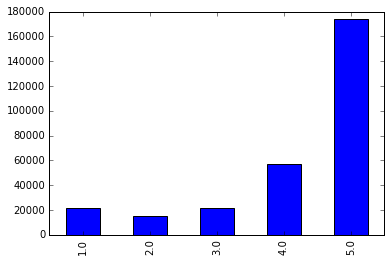

In [11]:
swissDF.overall.value_counts().sort_index().plot.bar()

Out of interest, we'll group the reviews by year and look for a trend

In [12]:
swissDF['year'] = swissDF['reviewTime'].astype(str)

In [13]:
swissDF['year'] = swissDF['year'].apply(lambda x: x[-4:])

In [14]:
swissDF.head()

,asin,helpful,overall,reviewText,reviewTime,reviewerID,reviewerName,summary,unixReviewTime,year
0,B000R9AAJA,"[0, 0]",5.0,Speakers are loud and clear. They work great! ...,"11 22, 2012",A0023922YYT81KP1CWU4,Steven Caruso,Great!,1353542400,2012
1,B002FU5QM0,"[0, 0]",5.0,these speakers work well for using at my desk ...,"11 18, 2012",A00277003AGRC9WJJ555O,Alex,Works well,1353196800,2012
2,B003LCV4RM,"[0, 1]",5.0,it works like a CHARM!!! love it all the raoch...,"10 18, 2013",A00311601FOXCO2AIRNIF,fatima khan,wonderful,1382054400,2013
3,B0015C30J0,"[0, 0]",5.0,Came within a day of my purchase. I was happy ...,"12 7, 2013",A00343841Z6YRUBZ6K0W3,Kevin Truong,Nice,1386374400,2013
4,B002FU5QLQ,"[0, 0]",4.0,I sometimes show videos in a variety of classr...,"04 21, 2014",A0047322388NOTO4N8SKD,Robert Patton,"Simple, small, adequate",1398038400,2014


In [15]:
yearGroup =swissDF.groupby(['year'])

In [16]:
yearGroup['overall'].agg(['count', 'mean'])

,count,mean
year,,
2000,12,4.416667
2001,49,3.918367
2002,70,3.942857
2003,205,4.136585
2004,307,3.491857
2005,826,3.984262
2006,1893,4.078711
2007,5514,4.273486
2008,7366,4.250068


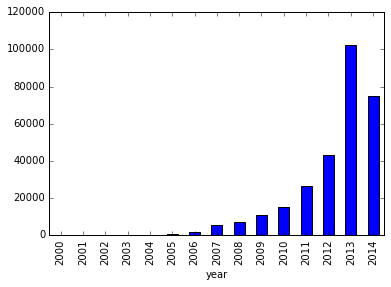

In [17]:
yearGroup['overall'].count().plot.bar()

It seems like the number of reviews is growing with a huge increase in 2013. 2014 seems smaller in comparison but this data was collected in July 2014 so some of it is missing.

The mean of the scores is pretty stable, with a dip in 2004 probably caused because of one or two bad products and the small number of reviews